### Dataset

The dataset was pulled from https://www.kaggle.com/datasets/arashnic/faces-age-detection-dataset?resource=download-directory

There are two folders, first one is called **faces**, contains files with images and appropriate label. The second folder is called **faces_02**, contains the iamges, but without labels. Thus, the **faces*** will be used for both training and testing. The **faces_02** can be used for fun ?

# EDA (Nikolai)

Let's do neccessary imports:

In [1]:
import os
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

I also define the batch sizes:

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 30

Let's retrieve the names and appropriate labels into dataframe:

In [3]:
df = pd.read_csv(os.path.join("faces", "train.csv"))
df

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE
...,...,...
19901,2482.jpg,MIDDLE
19902,20085.jpg,YOUNG
19903,19663.jpg,MIDDLE
19904,10132.jpg,MIDDLE


Let's check out the classes we have:

In [4]:
df["Class"].value_counts()

Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64

Let's separate paths according to their classes:

In [5]:
young_p = list(df[df["Class"] == "YOUNG"]["ID"])
middle_p = list(df[df["Class"] == "MIDDLE"]["ID"])
old_p = list(df[df["Class"] == "OLD"]["ID"])
print(f"Training data has: {len(young_p)} images of young, {len(middle_p)} images of middle-aged and {len(old_p)} images of oldies")

Training data has: 6706 images of young, 10804 images of middle-aged and 2396 images of oldies


We can visualize random images of each class:

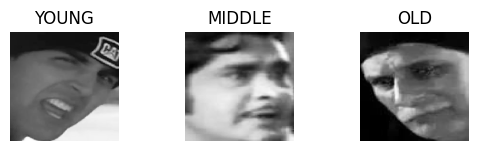

In [6]:
random_iamges = [
    (random.choice(young_p), "YOUNG"),
    (random.choice(middle_p), "MIDDLE"),
    (random.choice(old_p), "OLD")
]
fig = plt.figure()
i = 1
for (path, label) in random_iamges:
    ax = fig.add_subplot(3, 3, i)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(os.path.join("faces", "Train", path), target_size = (IMAGE_SIZE,IMAGE_SIZE), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
    i += 1
plt.show()

### IMPORTANT: next cell itself consumes around ~5gb of RAM

In [7]:
#def img2np(path, list_of_filename, size=(IMAGE_SIZE, IMAGE_SIZE)):
#    img_list = []
#    for i, fn in enumerate(list_of_filename):
#        if i % 500 == 0:
#            print(f"Parsing {i}/{len(list_of_filename)}")
#        fp = os.path.join(path, fn)
#        current_image = image.load_img(fp, target_size = size, color_mode = 'grayscale')
#        img_ts = image.img_to_array(current_image).ravel()
#        img_list.append(img_ts)
#    return np.array(img_list)

#common_path = os.path.join("faces", "Train")
#young = img2np(common_path, young_p)
#middle = img2np(common_path, middle_p)
#old = img2np(common_path, old_p)


The code cells above and below are commented as they are computentially consuming, but may be launched upon desire:

In [ ]:
#def find_mean_img(full_mat, title, size=(IMAGE_SIZE, IMAGE_SIZE)):
#    mean_img = np.mean(full_mat, axis = 0)
#    mean_img = mean_img.reshape(size)
#    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
#    plt.title(f'AVG {title} case')
#    plt.axis('off')
#    plt.show()
#    return mean_img
#
#young_mean_img = find_mean_img(young, 'young')
#middle_mean_img = find_mean_img(middle, 'middle')
#old_mean_img = find_mean_img(old, 'old')

## Loading Dataset

keras requires images distributed in different folders according to their classes, let's do that:

In [8]:
import shutil
if not os.path.exists("training"):
    os.mkdir("training")
young_folder = os.path.join("training", "young")
middle_folder = os.path.join("training", "middle")
old_folder = os.path.join("training", "old")
if not os.path.exists(young_folder):
    os.mkdir(young_folder)
if not os.path.exists(middle_folder):
    os.mkdir(middle_folder)
if not os.path.exists(old_folder):
    os.mkdir(old_folder)
common_path = os.path.join("faces", "Train")
for p in young_p: shutil.copy(os.path.join(common_path, p), young_folder) 
print("Copied young")
for p in middle_p: shutil.copy(os.path.join(common_path, p), middle_folder)
print("Copied middle")
for p in old_p: shutil.copy(os.path.join(common_path, p), old_folder)
print("Copied oldies")

Copied young
Copied middle
Copied oldies


In [9]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    "training",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 19906 files belonging to 3 classes.


In [10]:
classes = ds.class_names
print(f'Classes for classification: {str(classes)}')

Classes for classification: ['middle', 'old', 'young']


In [11]:
def splitDataset(data, train_split=0.7, val_split=0.2, test_split=0.1):
    data_size = len(data)
    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = splitDataset(ds)

Let's take a look on how the batch in the training ds looks like:

In [12]:
input_shape = None
for batch, labels in train_ds.take(1):
    input_shape = batch.shape
    print(input_shape)
    print(labels.numpy())

(30, 256, 256, 3)
[2 2 0 0 0 1 0 1 0 0 0 0 0 1 2 1 0 0 0 2 0 0 2 2 0 0 0 0 0 0]


In [13]:
test_ds

<_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

We should also apply normalization for the better quality of training

In [14]:
norm_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (norm_layer(x), y))
val_ds = val_ds.map(lambda x, y: (norm_layer(x), y))
test_ds = test_ds.map(lambda x, y: (norm_layer(x), y))

As the common sense suggests, the features of the faces differ substantially from class to class, that's why we pick CNN as it is able to learn these features and complete classification task.

# Model (Milan)